# 0.0 Import Libraries

In [ ]:
pip install spectral mat73  einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import math

from einops import rearrange
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io
import torch.utils.data
import scipy.io as sio
import mat73
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Import libraries
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.io
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical
from keras.models import Sequential,  Model,load_model
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, MaxPool1D, GaussianNoise, GlobalMaxPooling1D, Conv1D, GlobalAveragePooling1D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
import math, time

# 1.0 Upload Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls '/content/drive/MyDrive/A02_RemoteSensingData/MUUFLGUlfportDataCollection/'

best_model_weights.pth			   muufl_gulfport_campus_w_lidar_1.mat
lidar_model11_iter1.h5			   muufl_scene_labels_screenshot.png
muufl_best_model_weights.pth		   MUUFL_TruthForSubImage.mat
muufl_gulfport_campus_1_hsi_220_label.mat  README.md
muufl_gulfport_campus_3.mat		   tgt_lab_spectra.mat
muufl_gulfport_campus_4.mat		   train_test_split_lidar11_iter1.npz


In [ ]:
# 2.1 Define the class information
class_info = [
    (1, "Tree", 150, 23246, 23396),
    (2, "Mostly grass", 150, 4270,4420),
    (3, "Mixed ground surface", 150, 6882, 7032),
    (4, "Dirt and sand", 150, 1826, 1976),
    (5, "Road", 150, 6687, 6837),
    (6, "Water", 150, 466, 616),
    (7, "Building shadow", 150, 2233, 2383),
    (8, "Building", 150, 6240, 6390),
    (9, "Sidewalk", 150, 1385, 1535),
    (10, "Yellow curb", 150, 183, 333),
    (11, "Cloth panels", 150, 269, 419)

]

class_dict = {class_number: {"class_name": class_name, "training": training, "test": test, "samples": samples} for class_number, class_name, training, test, samples in class_info}

for class_number, class_info in class_dict.items():
    print(f"Class {class_number}: {class_info['class_name']}")
    print(f"Training Samples: {class_info['training']}")
    print(f"Test Samples: {class_info['test']}")
    print(f"Total Samples: {class_info['samples']}")
    print()


print(class_dict)

Class 1: Tree
Training Samples: 150
Test Samples: 23246
Total Samples: 23396

Class 2: Mostly grass
Training Samples: 150
Test Samples: 4270
Total Samples: 4420

Class 3: Mixed ground surface
Training Samples: 150
Test Samples: 6882
Total Samples: 7032

Class 4: Dirt and sand
Training Samples: 150
Test Samples: 1826
Total Samples: 1976

Class 5: Road
Training Samples: 150
Test Samples: 6687
Total Samples: 6837

Class 6: Water
Training Samples: 150
Test Samples: 466
Total Samples: 616

Class 7: Building shadow
Training Samples: 150
Test Samples: 2233
Total Samples: 2383

Class 8: Building
Training Samples: 150
Test Samples: 6240
Total Samples: 6390

Class 9: Sidewalk
Training Samples: 150
Test Samples: 1385
Total Samples: 1535

Class 10: Yellow curb
Training Samples: 150
Test Samples: 183
Total Samples: 333

Class 11: Cloth panels
Training Samples: 150
Test Samples: 269
Total Samples: 419

{1: {'class_name': 'Tree', 'training': 150, 'test': 23246, 'samples': 23396}, 2: {'class_name': 'M

In [ ]:
# path
path ='/content/drive/MyDrive/A02_RemoteSensingData/MUUFLGUlfportDataCollection/'
hsi_data_campus3=scipy.io.loadmat( path + "muufl_gulfport_campus_3.mat")
hsi_data_campus4=scipy.io.loadmat( path + "muufl_gulfport_campus_4.mat")
lidar_data= scipy.io.loadmat(path + "muufl_gulfport_campus_1_hsi_220_label.mat")
gt_data=scipy.io.loadmat(path + "MUUFL_TruthForSubImage.mat")

In [ ]:
import scipy.io
import numpy as np

# Load the MATLAB file
mat = scipy.io.loadmat(path + "muufl_gulfport_campus_1_hsi_220_label.mat")

# Access the hyperspectral data
hsi_data = mat['hsi']

# Depending on the structure of the .mat file, you might have to access nested structures
# For example, if the data is nested within a structure or cell array in MATLAB, you might need to do something like this:
hsi_data = mat['hsi'][0,0]['Data']
print('hsi_data .shape:',hsi_data .shape)

# Access Ground truuth

hsi = ((mat['hsi'])[0])[0]
# RGB Image
rgbIm = hsi[-1]

# Ground truth
truth = ((hsi[-2])[0])[-1]
truth = truth[-1]
print('truth.shape:', truth.shape)

# Access LiDAR
lidar = ((((hsi[-4])[0])[0])[0])[0]

# x, y, z. z contains Height and Intensity
x, y, z, info = lidar[0], lidar[1], lidar[2], lidar[3]

print('x.shape:', x.shape)
print('y.shape:', y.shape)
print('z.shape:', z.shape)


hsi_data .shape: (325, 220, 64)
truth.shape: (325, 220)
x.shape: (1, 220)
y.shape: (1, 325)
z.shape: (325, 220, 2)


In [ ]:
hsi_data=hsi_data
lidar_data=z
gt_data=truth
print('hsi_data shap:', hsi_data.shape)
print('lidar_data shap:', lidar_data.shape)
print('gt_data shap:', gt_data.shape)

hsi_data shap: (325, 220, 64)
lidar_data shap: (325, 220, 2)
gt_data shap: (325, 220)


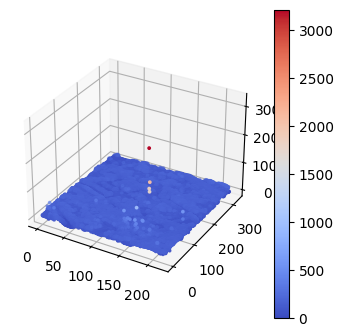

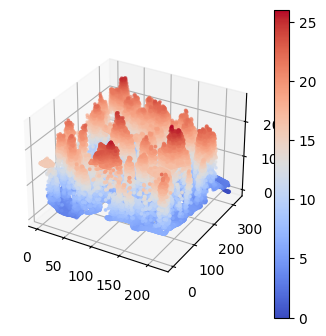

In [ ]:
# Create meshgrid
# Height and Intesity of LiDAR
height = z[:,:,0]
intensity = z[:,:,1]
# Shape of Height and Intensity is same
row, col = intensity.shape
x = np.arange(0, col, 1)
y = np.arange(0, row, 1)
xx, yy = np.meshgrid(x, y)

# 3D visualization of Intensity
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
I = ax.scatter(xx, yy, intensity, c=intensity, s= 3, cmap= 'coolwarm')
fig.colorbar(I, ax= ax)
plt.show()

# 3D visualization of Height
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
I = ax.scatter(xx, yy, height, c=height, s= 3, cmap= 'coolwarm')
fig.colorbar(I, ax= ax)
plt.show()

# 2.0 Data Preprocessing

### 2.1 Find the NxN neighbourhood around each pixel

In [ ]:
# 2.2 Samples Extraction

# Create a mask with all class labels
mask = np.copy(gt_data)

# Set the background class to 0
mask[mask == 0] = 0

# Define patch size and stride
patch_size = 9
stride = 1

# Create an empty list to store patches and labels
hsi_samples = []
lidar_samples = []
labels = []

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, class_dict):
    return all(class_count[class_num] == class_dict[class_num]["samples"] for class_num in class_dict.keys())

while not all_classes_completed(class_count, class_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        coords = np.argwhere((gt_data == label) & (mask > 0))

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_data.shape[0] and j_start >= 0 and j_end <= hsi_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < class_dict[label]["samples"]:
                    # Append the patch and its label to the list
                    hsi_samples.append(hsi_patch)
                    lidar_samples.append(lidar_patch)
                    labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, class_dict):
                        break

# Convert the list of patches and labels into arrays
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)
print('hsi_samples shape:', hsi_samples.shape)
print('lidar_samples shape:', lidar_samples.shape)
print('labels shape:', labels.shape)

hsi_samples shape: (55337, 9, 9, 64)
lidar_samples shape: (55337, 9, 9, 2)
labels shape: (55337,)


### 2.2 Split the Split the data into train-test, save in npz file and load the file

In [ ]:
from sklearn.model_selection import train_test_split

# Initialize empty lists to store the train and test samples
hsi_train = []
hsi_test = []
lidar_train = []
lidar_test = []
y_train = []
y_test = []

# Split the data for each class
for class_number, class_info in class_dict.items():
    # Get the indices of the samples for this class
    class_indices = np.where(labels == class_number)[0]

    # Shuffle the class indices
    np.random.shuffle(class_indices)

    # Split the class indices into training and test indices
    train_indices = class_indices[:class_info["training"]]
    test_indices = class_indices[class_info["training"]:class_info["samples"]]

    # Add the selected training samples to the train lists
    hsi_train.append(hsi_samples[train_indices])
    lidar_train.append(lidar_samples[train_indices])
    y_train.append(labels[train_indices])

    # Add the remaining samples to the test lists
    hsi_test.append(hsi_samples[test_indices])
    lidar_test.append(lidar_samples[test_indices])
    y_test.append(labels[test_indices])

# Concatenate the train and test lists to create the train and test arrays
hsi_train = np.concatenate(hsi_train)
hsi_test = np.concatenate(hsi_test)
lidar_train = np.concatenate(lidar_train)
lidar_test = np.concatenate(lidar_test)
y_train = np.concatenate(y_train)
y_test = np.concatenate(y_test)

# Print the shapes of the train and test arrays
print('hsi_train shape:', hsi_train.shape)
print('hsi_test shape:', hsi_test.shape)
print('lidar_train shape:', lidar_train.shape)
print('lidar_test shape:', lidar_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


hsi_train shape: (1650, 9, 9, 64)
hsi_test shape: (53687, 9, 9, 64)
lidar_train shape: (1650, 9, 9, 2)
lidar_test shape: (53687, 9, 9, 2)
y_train shape: (1650,)
y_test shape: (53687,)


### 2.3 Normalize train and test data

In [ ]:
# Normalize channel 1(Height) of the train data
ch1 = hsi_train[:, :, :, 0]
pmin = np.amin(ch1)
pmax = np.amax(ch1)
ch1 = (ch1-pmin) / (pmax- pmin)

# Normalize channel 2(Intensity) of the train data
ch2 = hsi_train[:, :, :, 1]
pmin1 = np.amin(ch2)
pmax1 = np.amax(ch2)
ch2 = (ch2-pmin1) / (pmax1- pmin1)

hsi_train[:,:,:,0] = ch1
hsi_train[:,:,:,1] = ch2

# Normalize channel 1(Height) the test data
ch3 = hsi_test[:, :, :, 0]
ch3 = (ch3-pmin) / (pmax- pmin)

# Normalize channel 2(Intensity) of the test data
ch4 = hsi_test[:, :, :, 1]
ch4 = (ch4-pmin1) / (pmax1- pmin1)

hsi_test[:,:,:,0] = ch3
hsi_test[:,:,:,1] = ch4

print('ch1 shape:',ch1.shape)
print('ch2 shape:',ch2.shape)
print('ch3 shape:',ch3.shape)
print('ch4 shape:',ch4.shape)

ch1 shape: (1650, 9, 9)
ch2 shape: (1650, 9, 9)
ch3 shape: (53687, 9, 9)
ch4 shape: (53687, 9, 9)


### 2.4 One-hot encode labels

In [ ]:
# One hot encoding of labels
# Substract 1 from labels
y_train_adj = y_train - 1
y_test_adj = y_test - 1
# y_train_adj = y_train
# y_test_adj = y_test

# One hot encoding of labels
y_train = to_categorical(y_train_adj, num_classes = 11, dtype ="int32")
y_test = to_categorical(y_test_adj, num_classes = 11, dtype ="int32")

print('y_train.shape:',y_train.shape)
print('y_test.shape:',y_test.shape)


y_train.shape: (1650, 11)
y_test.shape: (53687, 11)


#3.0 Model Building

### 3.1 Configuration

In [ ]:
# 3.1 Configuration
class Config:
    def __init__(self,in_channels,num_patches,kernel_size,patch_size,emb_size, dim,depth,heads,dim_head,mlp_dim,num_classes,dropout,pos_emb_size,class_emb_size,stride, ):
        self.in_channels = in_channels
        self.num_patches = num_patches
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_head = dim_head
        self.mlp_dim = mlp_dim
        self.num_classes = num_classes
        self.dropout = dropout
        self.pos_emb_size = pos_emb_size
        self.class_emb_size = class_emb_size
        self.stride = stride


### 3.2 EmbeddingPatches

In [ ]:

class PatchEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.proj = nn.Conv2d(
            config.in_channels,
            config.emb_size,
            kernel_size=config.patch_size,
            stride=config.stride,
        )
        self.pos_embedding = nn.Parameter(torch.zeros(1, config.num_patches + 1, config.emb_size))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.emb_size))

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        x = torch.cat((self.cls_token.expand(B, -1, -1), x), dim=1)
        x = x + self.pos_embedding[:, :x.size(1)]
        return x



### 3.2 Optianl Adding bandoutput

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, lidar_config, hsi_config):
        super(CrossAttention, self).__init__()

        # Define module parameters
        self.dim_head = lidar_config.dim_head
        self.num_patches=hsi_config.num_patches
        self.num_classes=hsi_config.num_classes
        self.num_heads = lidar_config.heads
        self.sqrt_dim_head = math.sqrt(self.dim_head)

        # Define linear layers for transforming Q, K, and V
        self.to_q = nn.Linear(lidar_config.dim, self.dim_head * self.num_heads, bias=False)
        self.to_k = nn.Linear(hsi_config.dim, self.dim_head * self.num_heads, bias=False)
        self.to_v = nn.Linear(lidar_config.dim, self.dim_head * self.num_heads, bias=False)

        self.to_out = nn.Linear( self.num_heads* self.dim_head,self.num_patches )  # added

        # Final classification layer
        self.class_layer = nn.Linear(self.num_patches, self.num_classes)

    def forward(self, lidar, hsi):
        B, N_lidar, _ = lidar.size()
        _, N_hsi, _ = hsi.size()

        outputs = []
        attn_scores = []  # List to store attention scores

       # Iterate over lidar and hsi patches
        for i in range(2, N_lidar):
        #for i in range(N_lidar):

            lidar_patch = lidar[:, i].unsqueeze(1)  # Add a dimension for number of patches
            for j in range(1, N_hsi):
            #for j in range(N_hsi):

                hsi_patch = hsi[:, j].unsqueeze(1)  # Add a dimension for number of patches
                Q = self.to_q(lidar_patch)
                K = self.to_k(hsi_patch)
                V = self.to_v(lidar_patch)

                Q = Q / self.sqrt_dim_head
                attn_weights = F.softmax(Q @ K.transpose(-2, -1), dim=-1)

                attn_output = attn_weights @ V
                attn_score = self.to_out(attn_output)  # added
                outputs.append(attn_output)
                attn_scores.append(attn_score)  # Store the attention scores



         # Concatenate all the outputs
        output = torch.cat(outputs, dim=1)
        attn_scores = torch.cat(attn_scores, dim=1)  # Concatenate all the attention scores

        #Pass the output through the classification layer
        # Compute the mean over the sequence dimension
        #out_mean = torch.mean(output, dim=1)
        # Pass the output through the classification layer
        #out_class = self.class_layer(out_mean)

        # Compute max_attn_indices here, after you compute the attention scores
        #max_attn_indices = torch.argmax(attn_scores, dim=-1)

        #return output, out_class, attn_scores #max_attn_indices  # Return both output and attention scores
        return output, attn_scores #max_attn_indices  # Return both output and attention scores


In [ ]:
# class CrossAttention(nn.Module):
#     def __init__(self, lidar_config, hsi_config):
#         super(CrossAttention, self).__init__()

#         self.dim_head = lidar_config.dim_head
#         self.num_patches = hsi_config.num_patches
#         self.num_heads = lidar_config.heads
#         self.sqrt_dim_head = math.sqrt(self.dim_head)

#         self.to_q = nn.Linear(lidar_config.dim, self.dim_head * self.num_heads, bias=False)
#         self.to_k = nn.Linear(hsi_config.dim, self.dim_head * self.num_heads, bias=False)
#         self.to_v = nn.Linear(lidar_config.dim, self.dim_head * self.num_heads, bias=False)

#         self.to_out = nn.Linear(self.num_heads * self.dim_head, self.num_patches)

#         self.aggregator = nn.Linear(self.dim_head * self.num_heads, lidar_config.dim)


#     def forward(self, lidar, hsi):
#         B, N_lidar, _ = lidar.size()
#         _, N_hsi, _ = hsi.size()

#         outputs = torch.zeros((B, N_hsi, self.num_heads * self.dim_head), device=hsi.device)
#         attn_scores = torch.zeros((B, N_hsi), device=hsi.device)

#         for j in range(1, N_hsi):
#           hsi_patch = hsi[:, j].unsqueeze(1)
#           lidar_attn_outputs = []
#           lidar_attn_scores = []

#           for i in range(0, N_lidar):
#             lidar_patch = lidar[:, i].unsqueeze(1)

#             Q = self.to_q(lidar_patch)
#             K = self.to_k(hsi_patch)
#             V = self.to_v(lidar_patch)

#             Q = Q / self.sqrt_dim_head
#             attn_weights = F.softmax(Q @ K.transpose(-2, -1), dim=-1)

#             attn_output = attn_weights @ V
#             attn_score = self.to_out(attn_output)

#             lidar_attn_outputs.append(attn_output)
#             lidar_attn_scores.append(attn_score)

#           # Aggregate the attention outputs and scores for all LiDAR patches for the current HSI patch
#           aggregated_attn_output = self.aggregator(torch.stack(lidar_attn_outputs).sum(dim=0))
#           aggregated_attn_score = torch.stack(lidar_attn_scores).sum(dim=0)

#           outputs[:, j] = aggregated_attn_output.squeeze()
#           attn_scores[:, j] = aggregated_attn_score.squeeze()
#         return outputs, attn_scores


In [ ]:
class CrossAttentionModel(nn.Module):
    def __init__(self, hsi_config, lidar_config):
        super().__init__()
        self.hsi_patch_embedding = PatchEmbedding(hsi_config)
        self.lidar_patch_embedding = PatchEmbedding(lidar_config)
        self.cross_attention = CrossAttention(lidar_config, hsi_config)

    def forward(self, lidar_data, hsi_data):
        # Apply PatchEmbedding
        lidar_emb = self.lidar_patch_embedding(lidar_data)
        hsi_emb = self.hsi_patch_embedding(hsi_data)

        # Apply CrossAttention
        #output, out_class, attn_scores = self.cross_attention(lidar_emb, hsi_emb)
        output,  attn_scores = self.cross_attention(lidar_emb, hsi_emb)

        return output, attn_scores  # Return both output and attention scores


In [ ]:
#3.1.1 Parameters Setting
# Hsi configuration
hsi_config = Config(
    in_channels=81,  # Each sample covers 144 bands
    num_patches=64,  # 25*1*144 bands are grouped into 3600 groups
    kernel_size=1,  # Adjusted to match new patch size
    patch_size=9,  # Adjusted to match new patch size (5*5, 144/24=6)
    emb_size=128,  # Embedding size, this can be changed
    dim=128,  # Dimension of the transformer, this can be changed
    depth=6,  # Number of transformer layers, this can be changed
    heads=8,  # Number of attention heads, this can be changed
    dim_head=64,  # Dimension of each attention head, this can be changed
    mlp_dim=256,  # Dimension of the MLP layer, this can be changed
    num_classes=11,  # Number of classes, this can be changed
    dropout=0.4,  # Dropout rate, this can be changed
    pos_emb_size=128,  # Position embedding size, this can be changed
    class_emb_size=128,  # Class embedding size, this can be changed
    stride=1  # Stride for the convolution, this can be changed
)


# Lidara configuration
lidar_config = Config(
    in_channels=81,  # lidar group has 1 channels
    num_patches=2,  # 1 band for Lidar
    kernel_size=1,  # Adjusted to match new patch size
    patch_size=9, # Adjusted to match new patch size
    emb_size=128,  # Embedding size, this can be changed
    dim=128,  # Dimension of the transformer, this can be changed
    depth=6,  # Number of transformer layers, this can be changed
    heads=8,  # Number of attention heads, this can be changed
    dim_head=64,  # Dimension of each attention head, this can be changed
    mlp_dim=256,  # Dimension of the MLP layer, this can be changed
    num_classes=11,  # Number of classes, this can be changed
    dropout=0.4,  # Dropout rate, this can be changed
    pos_emb_size=128,  # Position embedding size, this can be changed
    class_emb_size=128,  # Class embedding size, this can be changed
    stride=1  # Stride for the convolution, this can be changed
)


NameError: name 'Config' is not defined

In [ ]:
# Assume we have loaded one batch of HSI and LiDAR data
hsi_batch = hsi_train  # Shape: (1650, 5, 5, 64)
lidar_batch = lidar_train  # Shape: (1650, 5, 5, 2)
print('hsi_batch sahpe before transpose:', hsi_batch.shape)
print('lidar_batch sahpe before transpose:', lidar_batch.shape)
# Transpose the data to have the channel dimension at the correct place
hsi_batch = hsi_batch.transpose(0, 3, 1, 2)  # New shape: (1650, 64, 5, 5)
lidar_batch = lidar_batch.transpose(0, 3, 1, 2)  # New shape: (2832, 2, 5, 5)
print('hsi_batch sahpe after transpose:', hsi_batch.shape)
print('lidar_batch shape after transpose:', lidar_batch.shape)

hsi_batch sahpe before transpose: (1650, 9, 9, 64)
lidar_batch sahpe before transpose: (1650, 9, 9, 2)
hsi_batch sahpe after transpose: (1650, 64, 9, 9)
lidar_batch shape after transpose: (1650, 2, 9, 9)


In [ ]:
# Assume we have loaded one batch of HSI and LiDAR data
one_hsi_batch = hsi_train[:1]  # Shape: (1, 5, 5, 64)
one_lidar_batch = lidar_train[:1]  # Shape: (1, 5, 5, 2)
print('one_hsi_batch sahpe before transpose:', one_hsi_batch.shape)
print('one_lidar_batch sahpe before transpose:', one_lidar_batch.shape)
# Transpose the data to have the channel dimension at the correct place
one_hsi_batch = one_hsi_batch.transpose(0, 3, 1, 2)  # New shape: (1, 64, 5, 5)
one_lidar_batch = one_lidar_batch.transpose(0, 3, 1, 2)  # New shape: (1, 2, 5, 5)
print('hsi_batch sahpe after transpose:', one_hsi_batch.shape)
print('lidar_batch shape after transpose:', one_lidar_batch.shape)

one_hsi_batch sahpe before transpose: (1, 9, 9, 64)
one_lidar_batch sahpe before transpose: (1, 9, 9, 2)
hsi_batch sahpe after transpose: (1, 64, 9, 9)
lidar_batch shape after transpose: (1, 2, 9, 9)


In [ ]:
hsi_patch_embedding = PatchEmbedding(hsi_config).to(device)
lidar_patch_embedding = PatchEmbedding(lidar_config).to(device)

# Assume we have loaded one batch of HSI and LiDAR data
one_hsi_batch = hsi_train[:1]  # Shape: (1, 5, 5, 64)
one_lidar_batch = lidar_train[:1]  # Shape: (1, 5, 5, 2)

# Now reshape HSI data such that spatial dimensions (5x5) are flattened and treated as channels
one_hsi_batch_flat = torch.from_numpy(one_hsi_batch.astype(np.float32).reshape(1, hsi_config.in_channels, hsi_config.num_patches, 1)).to(device)
one_lidar_batch_flat = torch.from_numpy(one_lidar_batch.astype(np.float32).reshape(1, lidar_config.in_channels, lidar_config.num_patches, 1)).to(device)

# Initialize the patch embedding module
hsi_patch_embedding = PatchEmbedding(hsi_config).to(device)
lidar_patch_embedding = PatchEmbedding(lidar_config).to(device)

# Pass the data through the patch embedding module
one_hsi_batch_embedded = hsi_patch_embedding(one_hsi_batch_flat).to(device)
one_lidar_batch_embedded = lidar_patch_embedding(one_lidar_batch_flat).to(device)

print('one_hsi_batch_embedded shape:', one_hsi_batch_embedded.shape)
print('one_lidar_batch_embedded shape:', one_lidar_batch_embedded.shape)


one_hsi_batch_embedded shape: torch.Size([1, 65, 128])
one_lidar_batch_embedded shape: torch.Size([1, 3, 128])


### Intialisation CrossAttention Class

In [ ]:
# Assume we have loaded one batch of HSI and LiDAR data
hsi_batch_6 = hsi_train[:6]  # Shape: (6, 5, 5, 64)
lidar_batch_6 = lidar_train[:6]  # Shape: (6, 5, 5, 2)

print("hsi_batch_6  shape:", hsi_batch_6 .shape)
print("lidar_batch_6 shape:", lidar_batch_6.shape)

# Now reshape HSI data such that spatial dimensions (5x5) are flattened and treated as channels
hsi_batch_6_flat = torch.from_numpy(hsi_batch_6.astype(np.float32).reshape(6, hsi_config.in_channels, hsi_config.num_patches, 1))
lidar_batch_6_flat = torch.from_numpy(lidar_batch_6.astype(np.float32).reshape(6, lidar_config.in_channels, lidar_config.num_patches, 1))

print("hsi_batch_6_flat  shape:", hsi_batch_6_flat .shape)
print("lidar_batch_6_flat shape:", lidar_batch_6_flat.shape)

hsi_batch_6_flat = hsi_batch_6_flat.to(device)  # Move the tensor to GPU
lidar_batch_6_flat = lidar_batch_6_flat.to(device)  # Move the tensor to GPU

hsi_patch_embedding = PatchEmbedding(hsi_config).to(device)
lidar_patch_embedding = PatchEmbedding(lidar_config).to(device)

# Pass the data through the patch embedding module
hsi_batch_6_embedded  = hsi_patch_embedding(hsi_batch_6_flat)
lidar_batch_6_embedded = lidar_patch_embedding(lidar_batch_6_flat)

device = torch.device("cuda:0")  # Define the device (GPU)

# Move the tensors to the desired device
hsi_batch_6_embedded = hsi_batch_6_embedded.to(device)
lidar_batch_6_embedded = lidar_batch_6_embedded.to(device)
print("hsi_batch_6_embedded  shape:", hsi_batch_6_embedded .shape)
print("lidar_batch_6_embedded shape:", lidar_batch_6_embedded.shape)

# Define the dimension of the model and the number of heads
d_model = hsi_config.emb_size  # the output dimension of PatchEmbedding
num_heads = hsi_config.heads  # the number of attention heads in the transformer

# Initialize CrossAttention module
cross_attention = CrossAttention(lidar_config, hsi_config).to(device)

# Apply the cross attention
output,attn_scores = cross_attention(lidar_batch_6_embedded, hsi_batch_6_embedded)


print("Cross attention output shape:", attn_scores.shape)
print("Output shape:", output.shape)


hsi_batch_6  shape: (6, 9, 9, 64)
lidar_batch_6 shape: (6, 9, 9, 2)
hsi_batch_6_flat  shape: torch.Size([6, 81, 64, 1])
lidar_batch_6_flat shape: torch.Size([6, 81, 2, 1])
hsi_batch_6_embedded  shape: torch.Size([6, 65, 128])
lidar_batch_6_embedded shape: torch.Size([6, 3, 128])
Cross attention output shape: torch.Size([6, 64, 64])
Output shape: torch.Size([6, 64, 512])


In [ ]:
# Create model instance
model = CrossAttentionModel(hsi_config, lidar_config).to(device)
model

CrossAttentionModel(
  (hsi_patch_embedding): PatchEmbedding(
    (proj): Conv2d(81, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (lidar_patch_embedding): PatchEmbedding(
    (proj): Conv2d(81, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (cross_attention): CrossAttention(
    (to_q): Linear(in_features=128, out_features=512, bias=False)
    (to_k): Linear(in_features=128, out_features=512, bias=False)
    (to_v): Linear(in_features=128, out_features=512, bias=False)
    (to_out): Linear(in_features=512, out_features=64, bias=True)
    (class_layer): Linear(in_features=64, out_features=11, bias=True)
  )
)

# 4.1  Training DataLoader for Cross Attention Module

In [ ]:
class HyperspectralDataset(Dataset):
    def __init__(self, hsi_samples, lidar_samples, labels):
        self.hsi_samples = hsi_samples
        self.lidar_samples = lidar_samples
        self.labels = labels

    def __len__(self):
        return len(self.hsi_samples)

    def __getitem__(self, idx):
        hsi_patch = self.hsi_samples[idx].float().to(device)
        lidar_patch = self.lidar_samples[idx].float().to(device)
        label = self.labels[idx]

        # Convert label to a tensor and reshape to match the model's output shape
        label = torch.tensor(label).repeat(hsi_patch.shape[1], 1).to(device)

        return hsi_patch, lidar_patch, label


In [ ]:
from sklearn.model_selection import train_test_split

# Initialize empty lists to store the train and test samples
hsi_train = []
hsi_test = []
lidar_train = []
lidar_test = []
y_train = []
y_test = []

# Split the data for each class
for class_number, class_info in class_dict.items():
    # Get the indices of the samples for this class
    class_indices = np.where(labels == class_number)[0]

    # Shuffle the class indices
    np.random.shuffle(class_indices)

    # Split the class indices into training and test indices
    train_indices = class_indices[:class_info["training"]]
    test_indices = class_indices[class_info["training"]:class_info["samples"]]

    # Add the selected training samples to the train lists
    hsi_train.append(hsi_samples[train_indices])
    lidar_train.append(lidar_samples[train_indices])
    y_train.append(labels[train_indices])

    # Add the remaining samples to the test lists
    hsi_test.append(hsi_samples[test_indices])
    lidar_test.append(lidar_samples[test_indices])
    y_test.append(labels[test_indices])

# Concatenate the train and test lists to create the train and test arrays
hsi_train = np.concatenate(hsi_train)
hsi_test = np.concatenate(hsi_test)
lidar_train = np.concatenate(lidar_train)
lidar_test = np.concatenate(lidar_test)
y_train = np.concatenate(y_train)
y_test = np.concatenate(y_test)

# Print the shapes of the train and test arrays
print('hsi_train shape:', hsi_train.shape)
print('hsi_test shape:', hsi_test.shape)
print('lidar_train shape:', lidar_train.shape)
print('lidar_test shape:', lidar_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

hsi_train shape: (1650, 9, 9, 64)
hsi_test shape: (53687, 9, 9, 64)
lidar_train shape: (1650, 9, 9, 2)
lidar_test shape: (53687, 9, 9, 2)
y_train shape: (1650,)
y_test shape: (53687,)


In [ ]:
# from tensorflow.keras.utils import to_categorical

# # One hot encoding of labels
# # Substract 1 from labels
# y_train_adj = augmented_training_labels - 1
# y_test_adj = y_test - 1

# # One hot encoding of labels
# y_train = to_categorical(y_train_adj, num_classes = 11, dtype ="int32")
# y_test = to_categorical(y_test_adj, num_classes = 11, dtype ="int32")

# print('y_train.shape:',y_train.shape)
# print('y_test.shape:',y_test.shape)

# labels_tensor = torch.tensor(y_train)
# #labels_tensor -= 1  # Shift label values to the range [0, C-1]
# print('labels_tensor:',labels_tensor.shape)

# # Assuming labels_tensor is one-hot encoded or contains probabilities
# labels_tensor = torch.argmax(labels_tensor, dim=1)
# y_train=labels_tensor
# print('y_train shape:',y_train.shape)

# y_test_tensor= torch.tensor(y_test)
# y_test_tensor -= 1  # Shift label values to the range [0, C-1]
# print('y_test_tensor shape:',y_test_tensor.shape)

# # Assuming labels_tensor is one-hot encoded or contains probabilities
# y_test_tensor = torch.argmax(y_test_tensor, dim=1)
# print('y_test_tensor shape:',y_test_tensor.shape)

# y_test= y_test_tensor
# print('y_test.shape:',y_test.shape)

In [ ]:
labels_tensor = torch.tensor(y_train)
labels_tensor -= 1  # Shift label values to the range [0, C-1]
print('labels_tensor:',labels_tensor.shape)



labels_tensor: torch.Size([1650])


In [ ]:
unique_classes = torch.unique(labels_tensor)
print("Unique classes:", unique_classes)

Unique classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])


In [ ]:
# labels_tensor = torch.tensor(labels)
# labels_tensor -= 1  # Shift label values to the range [0, C-1]
# print('labels_tensor:',labels_tensor.shape)
# unique_classes = torch.unique(labels_tensor)
# print("Unique classes:", unique_classes)

labels_tensor: torch.Size([55337])
Unique classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])


In [ ]:
# VIS Data prepration
from sklearn.model_selection import train_test_split

#Resahpe the data

# Move the input data to the desired device
# Assume we have loaded one batch of HSI and LiDAR data
hsi_batch = hsi_samples
lidar_batch=lidar_samples
label_batch=labels
print("hsi_batch shape:", hsi_batch.shape)
print("lidar_batch shape:", lidar_batch.shape)
print("label_batch shape:", label_batch.shape)

## Reshape the data
hsi_batch_flat = torch.from_numpy(hsi_batch.astype(np.float32).reshape(55337, hsi_config.in_channels, hsi_config.num_patches, 1))
lidar_batch_flat = torch.from_numpy(lidar_batch.astype(np.float32).reshape(55337, lidar_config.in_channels, lidar_config.num_patches, 1))

print("hsi_batch shape:", hsi_batch_flat .shape)
print("lidar_batch shape:", lidar_batch_flat.shape)

hsi_batch shape: (55337, 9, 9, 64)
lidar_batch shape: (55337, 9, 9, 2)
label_batch shape: (55337,)
hsi_batch shape: torch.Size([55337, 81, 64, 1])
lidar_batch shape: torch.Size([55337, 81, 2, 1])


In [ ]:
hsi_batch_flat = hsi_batch_flat.to(device)  # Move the tensor to GPU
lidar_batch_flat = lidar_batch_flat.to(device)  # Move the tensor to GPU

# Split into train and test
hsi_samples_train, hsi_samples_test, lidar_samples_train, lidar_samples_test, labels_train, labels_test = train_test_split(
    hsi_batch_flat, lidar_batch_flat, label_batch, test_size=0.5, random_state=42)
print('labels_train shape:',labels_train.shape)

# Split train into train and validation
hsi_samples_train, hsi_samples_val, lidar_samples_train, lidar_samples_val, labels_train, labels_val = train_test_split(
    hsi_samples_train, lidar_samples_train, labels_train, test_size=0.60, random_state=42)
#print('labels_train2 shape:',labels_train.shape)

# Now you have training, validation, and test data.
# Create Datasets
train_dataset = HyperspectralDataset(hsi_samples_train, lidar_samples_train, labels_train)
val_dataset = HyperspectralDataset(hsi_samples_val, lidar_samples_val, labels_val)
test_dataset = HyperspectralDataset(hsi_samples_test, lidar_samples_test, labels_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


labels_train shape: (27668,)


# 4.2 Training CorssAttentionMode ltraining

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy

# Define the batch size
batch_size = 32

# Create the data loader
#train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model instance
model = CrossAttentionModel(hsi_config, lidar_config).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.00) #loss 2.3866

# Initialize the best validation loss and best_model_wts before the training loop
best_val_loss = float('inf')  # Initialize with a very high value
best_model_wts = copy.deepcopy(model.state_dict())  # Initialize with the model weights

# Instantiate the loss function
criterion = nn.CrossEntropyLoss()

# Initialize the lowest_loss and best_model_wts before the training loop
lowest_loss = float('inf')  # Initialize with a very high value
best_model_wts = copy.deepcopy(model.state_dict())  # Initialize with the model weights

num_epochs = 100

for epoch in range(num_epochs):
    for batch_idx, (hsi_batch, lidar_batch, label_batch) in enumerate(train_loader):
        # Move tensors to the configured device
        hsi_batch = hsi_batch.to(device)
        lidar_batch = lidar_batch.to(device)
        label_batch = label_batch.to(device)  # Reshape labels
        # print('hsi_batch shape:', hsi_batch.shape)
        # print('lidar_batch:', lidar_batch.shape)
        # print('label_batch shape:', label_batch.shape)

        # Forward pass
        output,attn_scores  = model(lidar_batch, hsi_batch)
        #print('output shape:', output.shape)

        # Calculate loss
        loss = criterion(output.transpose(1, 2), label_batch.squeeze(2))

        # Print loss every 10 batches
        #if (batch_idx + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


        # If the loss is lower than the current lowest, save the model's state
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_wts = copy.deepcopy(model.state_dict())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the learning rate scheduler
        scheduler.step()

# Print finishing training
print('Finishing training')

# Save the best model weights
torch.save(best_model_wts, path+'muufl_p9_best_model_weights.pth')


Streaming output truncated to the last 5000 lines.
Epoch [86/100], Batch [192/346], Loss: 1.3557
Epoch [86/100], Batch [193/346], Loss: 0.9864
Epoch [86/100], Batch [194/346], Loss: 1.2832
Epoch [86/100], Batch [195/346], Loss: 2.1551
Epoch [86/100], Batch [196/346], Loss: 2.1437
Epoch [86/100], Batch [197/346], Loss: 1.7843
Epoch [86/100], Batch [198/346], Loss: 1.6571
Epoch [86/100], Batch [199/346], Loss: 1.4610
Epoch [86/100], Batch [200/346], Loss: 1.5861
Epoch [86/100], Batch [201/346], Loss: 1.7459
Epoch [86/100], Batch [202/346], Loss: 1.9681
Epoch [86/100], Batch [203/346], Loss: 1.7244
Epoch [86/100], Batch [204/346], Loss: 1.5707
Epoch [86/100], Batch [205/346], Loss: 1.3710
Epoch [86/100], Batch [206/346], Loss: 1.8394
Epoch [86/100], Batch [207/346], Loss: 2.0227
Epoch [86/100], Batch [208/346], Loss: 2.2224
Epoch [86/100], Batch [209/346], Loss: 1.3485
Epoch [86/100], Batch [210/346], Loss: 1.7164
Epoch [86/100], Batch [211/346], Loss: 1.0499
Epoch [86/100], Batch [212/34

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy

# Define the batch size
batch_size = 32

# Create the data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model instance
model = CrossAttentionModel(hsi_config, lidar_config).to(device)

# Instantiate the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1)  # loss 2.6101
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') # 2.5928
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0) # loss 2.6425
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=1) # loss 2.5945
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1) # loss 2..5951
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)#2.6039


# Initialize the best validation loss and best_model_wts before the training loop
best_val_loss = float('inf')  # Initialize with a very high value
best_model_wts = copy.deepcopy(model.state_dict())  # Initialize with the model weights

num_epochs = 200
patience = 50  # Number of epochs with no improvement after which training will be stopped
no_improve_epochs = 0  # Number of epochs with no improvement

for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for batch_idx, (hsi_batch, lidar_batch, label_batch) in enumerate(train_loader):
        # Move tensors to the configured device
        hsi_batch = hsi_batch.to(device)
        lidar_batch = lidar_batch.to(device)
        label_batch = label_batch.to(device)  # Reshape labels

        # Forward pass
        output, attn_scores  = model(lidar_batch, hsi_batch)

        # Calculate loss
        loss = criterion(output.transpose(1, 2), label_batch.squeeze(2))
        running_train_loss += loss.item() * hsi_batch.size(0)  # Multiply by batch size

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate epoch training loss
    epoch_train_loss = running_train_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for hsi_batch, lidar_batch, label_batch in val_loader:
            # Move tensors to the configured device
            hsi_batch = hsi_batch.to(device)
            lidar_batch = lidar_batch.to(device)
            label_batch = label_batch.to(device)  # Reshape labels

            # Forward pass
            output = model(lidar_batch, hsi_batch)

            # Calculate loss
            loss = criterion(output[0].transpose(1, 2), label_batch.squeeze(2))
            running_val_loss += loss.item() * hsi_batch.size(0)  # Multiply by batch size

    # Calculate epoch validation loss
    epoch_val_loss = running_val_loss / len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    # If the validation loss is lower than the current best, save the model's state
    if epoch_val_loss < best_val_loss:
        print(f'Validation Loss Decreased({best_val_loss:.6f}--->{epoch_val_loss:.6f}) \t Saving The Model')
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0  # reset count
    else:
        no_improve_epochs += 1

    # Check early stopping condition
    if no_improve_epochs > patience:
        print('Early stopping!')
        model.load_state_dict(best_model_wts)  # load best model
        break

    # Step the learning rate scheduler
    #scheduler.step(epoch_val_loss)

print('Finished training')

# Save the best model weights
torch.save(best_model_wts, path+'muufl_best_model_weights.pth')


Epoch [1/200], Train Loss: 70.8700, Val Loss: 51.4951
Validation Loss Decreased(inf--->51.495129) 	 Saving The Model
Epoch [2/200], Train Loss: 42.0242, Val Loss: 29.4395
Validation Loss Decreased(51.495129--->29.439477) 	 Saving The Model
Epoch [3/200], Train Loss: 25.6073, Val Loss: 19.7197
Validation Loss Decreased(29.439477--->19.719674) 	 Saving The Model
Epoch [4/200], Train Loss: 17.3049, Val Loss: 14.2144
Validation Loss Decreased(19.719674--->14.214400) 	 Saving The Model
Epoch [5/200], Train Loss: 13.1908, Val Loss: 11.5645
Validation Loss Decreased(14.214400--->11.564485) 	 Saving The Model
Epoch [6/200], Train Loss: 11.3333, Val Loss: 10.8401
Validation Loss Decreased(11.564485--->10.840082) 	 Saving The Model
Epoch [7/200], Train Loss: 10.7802, Val Loss: 10.2955
Validation Loss Decreased(10.840082--->10.295460) 	 Saving The Model
Epoch [8/200], Train Loss: 10.1617, Val Loss: 9.8754
Validation Loss Decreased(10.295460--->9.875372) 	 Saving The Model
Epoch [9/200], Train Los

In [ ]:
# Save the best model state
torch.save(best_model_wts, path+'best_model_weights.pth')


In [ ]:
# Load the saved model
best_model = CrossAttentionModel(hsi_config, lidar_config)

# Load the weights
best_model.load_state_dict(torch.load(path+'best_model_weights.pth'))

# Move the model to the GPU
best_model = best_model.to(device)

# Now your model is ready for making predictions on GPU


# 5.0 Load Trained Model

In [ ]:
# Load the model
model = CrossAttentionModel(hsi_config, lidar_config)
model.load_state_dict(torch.load(path+'muufl_p9_best_model_weights.pth'))
model.eval()  # set the model to evaluation mode

CrossAttentionModel(
  (hsi_patch_embedding): PatchEmbedding(
    (proj): Conv2d(81, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (lidar_patch_embedding): PatchEmbedding(
    (proj): Conv2d(81, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (cross_attention): CrossAttention(
    (to_q): Linear(in_features=128, out_features=512, bias=False)
    (to_k): Linear(in_features=128, out_features=512, bias=False)
    (to_v): Linear(in_features=128, out_features=512, bias=False)
    (to_out): Linear(in_features=512, out_features=64, bias=True)
    (class_layer): Linear(in_features=64, out_features=11, bias=True)
  )
)

In [ ]:
# Load the model
model = CrossAttentionModel(hsi_config, lidar_config)
model.load_state_dict(torch.load(path+'muufl_p9_best_model_weights.pth'))
model.eval()  # set the model to evaluation mode

# Move the model to the GPU
#
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
hsi_patch_embedding.pos_embedding 	 torch.Size([1, 65, 128])
hsi_patch_embedding.cls_token 	 torch.Size([1, 1, 128])
hsi_patch_embedding.proj.weight 	 torch.Size([128, 81, 1, 1])
hsi_patch_embedding.proj.bias 	 torch.Size([128])
lidar_patch_embedding.pos_embedding 	 torch.Size([1, 3, 128])
lidar_patch_embedding.cls_token 	 torch.Size([1, 1, 128])
lidar_patch_embedding.proj.weight 	 torch.Size([128, 81, 1, 1])
lidar_patch_embedding.proj.bias 	 torch.Size([128])
cross_attention.to_q.weight 	 torch.Size([512, 128])
cross_attention.to_k.weight 	 torch.Size([512, 128])
cross_attention.to_v.weight 	 torch.Size([512, 128])
cross_attention.to_out.weight 	 torch.Size([64, 512])
cross_attention.to_out.bias 	 torch.Size([64])
cross_attention.class_layer.weight 	 torch.Size([11, 64])
cross_attention.class_layer.bias 	 torch.Size([11])


In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])


In [ ]:
# best_model=model # load your best model

# Move the model to the correct device
best_model = model.to(device)

# Ensure the model is in evaluation mode
best_model.eval()

# Initialize a list to hold all the predictions and attention scores
all_predictions = []
all_attn_scores = []

# Loop over the validation set
for hsi_batch, lidar_batch, _ in val_loader:  # we don't need the labels for predictions
    # Move the batch to the desired device
    hsi_batch = hsi_batch.to(device)
    lidar_batch = lidar_batch.to(device)

    # Pass the batch through the model
    with torch.no_grad():
        output, attn_scores = best_model(lidar_batch, hsi_batch)

        # Add the predictions and attention scores to our lists
        all_predictions.append(output.cpu().numpy())
        all_attn_scores.append(attn_scores.cpu().numpy())

# Concatenate all predictions and attention scores into a single numpy array
all_predictions = np.concatenate(all_predictions)
all_attn_scores = np.concatenate(all_attn_scores)

# Now you can use the predictions and attention scores as needed
print('all_predictions shape:', all_predictions.shape)
print('all_attn_scores shape:', all_attn_scores.shape)



all_predictions shape: (16601, 64, 512)
all_attn_scores shape: (16601, 64, 64)


# Band Selection

Calculate the variance of the feature vectors for each band across all samples and then find the bands with the maximum variance

In [ ]:
# First, take the mean across all samples and heads. This will result in a single 144-dim vector.
mean_attention = np.mean(all_attn_scores, axis=(0, 1))
print('mean_attention:',mean_attention.shape)

# Then, sort the bands by attention. This will give you the band indices in descending order of attention.
sorted_band_indices = np.argsort(mean_attention)[::-1]
print('sorted_band_indices :',sorted_band_indices.shape)

# If you want to see the attention values as well, you can sort the mean_attention array in the same order.
sorted_attention_values = mean_attention[sorted_band_indices]
print('sorted_attention_values :',sorted_attention_values.shape)

N = 50  # Top N bands
top_N_bands = sorted_band_indices[:N]
top_N_attention_values = sorted_attention_values[:N]

# Print the top N band indices with their attention scores
print(f"Top {N} bands based on the mean attention score:")
for band_index, attention_value in zip(top_N_bands, top_N_attention_values):
    print(f"Band index: {band_index}, Mean attention score: {attention_value}")

# Print the list of top N band indices
print("\nList of top {} band indices:".format(N))
print(top_N_bands.tolist())


mean_attention: (64,)
sorted_band_indices : (64,)
sorted_attention_values : (64,)
Top 50 bands based on the mean attention score:
Band index: 21, Mean attention score: 63.02592086791992
Band index: 62, Mean attention score: 60.26506805419922
Band index: 60, Mean attention score: 55.706642150878906
Band index: 4, Mean attention score: 50.740474700927734
Band index: 34, Mean attention score: 47.5483512878418
Band index: 23, Mean attention score: 44.8641357421875
Band index: 20, Mean attention score: 44.70694351196289
Band index: 10, Mean attention score: 34.23902893066406
Band index: 45, Mean attention score: 33.21865463256836
Band index: 19, Mean attention score: 32.920753479003906
Band index: 51, Mean attention score: 32.7322883605957
Band index: 27, Mean attention score: 28.580551147460938
Band index: 39, Mean attention score: 25.99041748046875
Band index: 46, Mean attention score: 24.747472763061523
Band index: 8, Mean attention score: 22.008190155029297
Band index: 63, Mean attentio

In [ ]:
band_50=[47, 38, 51, 8, 14, 36, 55, 10, 9, 20, 4, 57, 53, 7, 3, 37, 16, 11, 54, 1, 39, 34, 43, 25, 6, 56, 27, 23, 0, 30, 52, 17, 26, 41, 29, 28, 49, 35, 12, 44, 50, 22, 42, 2, 63, 59, 61, 15, 32, 40]
band_45=[47, 38, 51, 8, 14, 36, 55, 10, 9, 20, 4, 57, 53, 7, 3, 37, 16, 11, 54, 1, 39, 34, 43, 25, 6, 56, 27, 23, 0, 30, 52, 17, 26, 41, 29, 28, 49, 35, 12, 44, 50, 22, 42, 2, 63]
band_40=[47, 38, 51, 8, 14, 36, 55, 10, 9, 20, 4, 57, 53, 7, 3, 37, 16, 11, 54, 1, 39, 34, 43, 25, 6, 56, 27, 23, 0, 30, 52, 17, 26, 41, 29, 28, 49, 35, 12, 44]
band_35=[47, 38, 51, 8, 14, 36, 55, 10, 9, 20, 4, 57, 53, 7, 3, 37, 16, 11, 54, 1, 39, 34, 43, 25, 6, 56, 27, 23, 0, 30, 52, 17, 26, 41, 29]
band_30=[47, 38, 51, 8, 14, 36, 55, 10, 9, 20, 4, 57, 53, 7, 3, 37, 16, 11, 54, 1, 39, 34, 43, 25, 6, 56, 27, 23, 0, 30]
band_25=[47, 38, 51, 8, 14, 36, 55, 10, 9, 20, 4, 57, 53, 7, 3, 37, 16, 11, 54, 1, 39, 34, 43, 25, 6]
band_20=[47, 38, 51, 8, 14, 36, 55, 10, 9, 20, 4, 57, 53, 7, 3, 37, 16, 11, 54, 1]
band_15=[47, 38, 51, 8, 14, 36, 55, 10, 9, 20, 4, 57, 53, 7, 3]
band_10=[47, 38, 51, 8, 14, 36, 55, 10, 9, 20]
band_5=[47, 38, 51, 8, 14]


In [ ]:
band_50_p11=[32, 28, 58, 40, 8, 37, 25, 34, 62, 24, 44, 3, 23, 21, 27, 56, 60, 63, 41, 50, 22, 55, 31, 51, 2, 16, 15, 5, 0, 12, 49, 46, 57, 30, 35, 4, 7, 33, 29, 47, 20, 48, 42, 39, 26, 13, 45, 61, 10, 11]

In [ ]:
band_50_p9=[21, 62, 60, 4, 34, 23, 20, 10, 45, 19, 51, 27, 39, 46, 8, 63, 2, 33, 24, 35, 59, 18, 15, 5, 9, 30, 44, 1, 22, 37, 56, 14, 50, 57, 36, 16, 17, 28, 26, 49, 42, 53, 11, 25, 58, 40, 6, 54, 32, 13]